## DISP

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import callbacks, optimizers, losses
from keras import backend as K
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pandas as pd

from hvsrUNet.module.GPRNet import GPRNet
from hvsrUNet.toolbox.smooth import smooth

In [2]:
dataset = np.load('disp.npz')
disp = dataset['disp']
v = dataset['v']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(disp, v, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
X_train = tf.expand_dims(X_train, axis=2)
y_train = tf.expand_dims(y_train, axis=2)
X_valid = tf.expand_dims(X_valid, axis=2)
y_valid = tf.expand_dims(y_valid, axis=2)
X_test = tf.expand_dims(X_test, axis=2)
y_test = tf.expand_dims(y_test, axis=2)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

(TensorShape([736, 512, 1]),
 TensorShape([736, 512, 1]),
 TensorShape([231, 512, 1]),
 TensorShape([231, 512, 1]),
 TensorShape([185, 512, 1]),
 TensorShape([185, 512, 1]))

In [ ]:
model = GPRNet(im_width=1, im_height=512, neurons=8, kern_sz=10,enable_dropout=False)
model.summary()


In [ ]:
name_checkpoint = 'checkpoints/disp/Weights/{epoch:05d}.keras' # 保存模型的路径。
log_dir = 'checkpoints/disp/Logs' # 日志文件保存的目录。
name_csv = 'checkpoints/disp/Logs/disp.csv' # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
lr_val = 0.0001
batch_size = 32
epochs = 10000
n_batches = len(X_train) / batch_size
n_batches = int(np.ceil(n_batches))

def R2_score(v_true, v_pred):
    ssres = K.sum(K.square(v_true - v_pred))
    sstot = K.sum(K.square(v_true - K.mean(v_true)))
    return 1 - ssres / sstot

model_checkpoint = callbacks.ModelCheckpoint(name_checkpoint, # 保存模型的路径。
                                #monitor='val_loss',         # 监控的数据。
                                monitor='val_R2_score',
                                verbose=0,                  # 日志显示模式，0或1。
                                save_best_only=False,       # True，那么最近验证误差最低的模型就不会被覆盖。
                                save_weights_only=False,    # True，那么只有模型的权重会被保存。
                                #mode='auto',                # {auto, min, max}的其中之一。
                                mode='max',
                                save_freq=5*n_batches)               # 'epoch'或整数。保存频率。

early_stopping = callbacks.EarlyStopping(monitor='val_loss', # 监控的数据。
                                min_delta=0,                    # 增大或减小的阈值，只有大于这个部分才算作improvement。
                                patience=100,                     # 没有进步的训练轮数，在这之后训练就会被停止。
                                verbose=0,                      # 日志显示模式，0或1。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                baseline=None,                  # 要监控的数量的基准值，如果模型没有显示出基准的改善，则训练将停止。
                                restore_best_weights=False)     # 是否从具有监视器数量的最佳值的时期恢复模型权重。如果为False，则使用在训练的最后一步获得的模型权重。

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', # 监控的数据。
                                factor=0.5,                     # 触发时将学习率乘以系数的因数。
                                patience=15,                    # 没有进步的训练轮数，在这之后训练速率会被降低。
                                verbose=0,                      # 整数。0：安静，1：更新信息。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                min_delta=0.000001,               # 对于测量新阈值的阈值，只关注巨大的变化。
                                cooldown=0,                     # 在lr被降低之后，训练将在cooldown内的epoch之后继续。
                                min_lr=0)                       # 学习率的下边界。

csv_logger = callbacks.CSVLogger(name_csv, # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
                                separator=',',              # 用于隔开值的字符串。
                                append=False)               # 如果为True，则将数据添加到现有文件中，而不会重新启动。

optimizer = optimizers.Adam(learning_rate=lr_val)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mse', R2_score])

history = model.fit(X_train, y_train,
          validation_data=[X_valid,y_valid],
                  epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                   verbose=1)

In [ ]:
training_log = pd.read_csv('checkpoints/hvsr/Logs/hvsr.csv')
training_log.head()

mse_loss = training_log['loss']
val_mse_loss = training_log['val_loss']
acc = training_log['R2_score']
val_acc = training_log['val_R2_score']

accu = {'mse_loss': mse_loss, 
        'val_mse_loss': val_mse_loss,
        'acc': acc,
        'val_acc': val_acc}

with plt.style.context('ggplot'):
    sns.set_theme(style='darkgrid')
    fig, axes = plt.subplots(2, 2, figsize=(8, 4))
    for ax, (name, value) in zip(axes.flatten(), accu.items()):
        ax.plot(value, label=name, color='black')
        ax.set_xlabel('Epochs')
        ax.legend()
        ax.set_title(name)
    
    plt.tight_layout()
    plt.show()
    

In [ ]:
#model.load_weights('checkpoints/disp/Weights/00650.keras')
#model.load_weights('checkpoints/Weights/disp/00650.keras')

In [10]:
ypred = model.predict(X_test[:100, ...])
#ypred = model.predict(X_train)

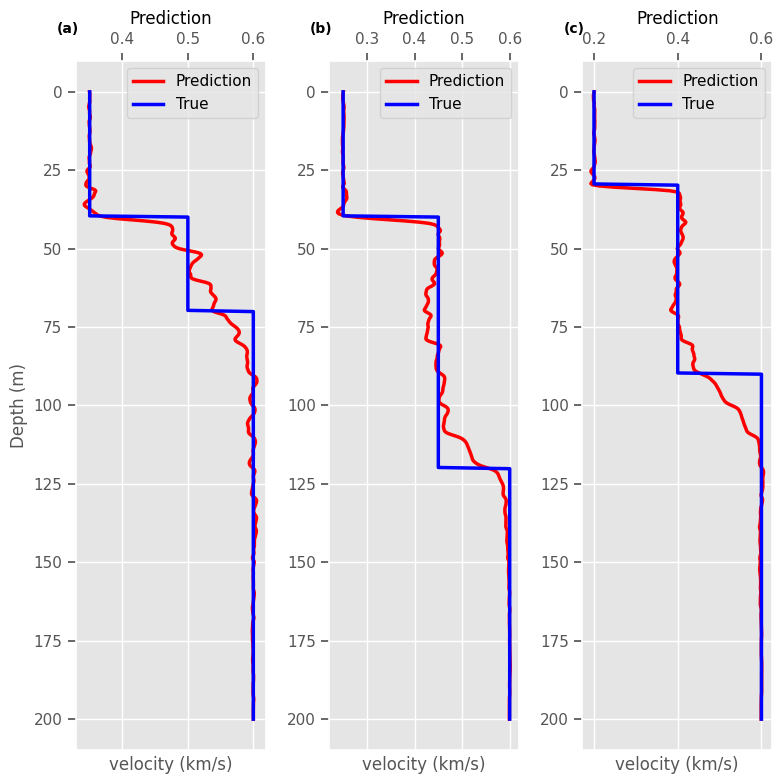

In [13]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)
        yy = smooth(np.squeeze(ypred[i, ...]), window_len=10, window='blackman')
        x1 = np.linspace(0, 200, len(yy))
        x2 = np.linspace(0, 200, len(y_test[i, ...]))

        ax.plot(yy, x1, color='red', label='Prediction', linewidth=2.5)
        ax.plot(y_test[i, ...], x2, color='blue', label='True', linewidth=2.5)
        ax.set_title('Prediction')
        ax.set_xlabel('velocity (km/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()